In [ ]:
## https://aspiresoftware.in/blog/rasa-nlu-intent-classification-using-different-pipeline/

In [1]:
# Import the required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from rasa_nlu.model import Trainer
from rasa_nlu.test import run_evaluation
from rasa_nlu import config
from rasa_nlu.training_data import load_data
import random
import time

import sys
import spacy
import sys
import warnings
warnings.filterwarnings("ignore")
import tensorflow

In [1]:
!python -m spacy download en_core_web_sm

In [2]:
nlp = spacy.load("en_core_web_sm")

In [7]:
# Importing the data
data = "./data/data.json"

In [9]:
initial_data = pd.read_json(data)

In [10]:
def select_examples(initial_data, nb_of_examples):
    """
    Select training and testing examples from Rasa NLU data based on the specified number of examples.

    :param initial_data: Rasa NLU data
    :param nb_of_examples: Number of examples to use as a threshold for data splitting
    :return: Training and testing dataframes after splitting the initial data
    """

    # If the specified number of examples is greater than the available examples, adjust it.
    if nb_of_examples > len(initial_data["rasa_nlu_data"]["common_examples"]):
        nb_of_examples = len(initial_data["rasa_nlu_data"]["common_examples"])

    training_examples_list = []
    test_examples_list = []
    training_df = initial_data.copy()
    test_df = initial_data.copy()

    # Create a DataFrame from the common examples in the initial data
    examples_df = pd.DataFrame.from_records(initial_data["rasa_nlu_data"]["common_examples"])
    
    # Calculate the distribution of examples per intent
    serie_distOfExamples = examples_df["intent"].value_counts() / len(examples_df)
    
    for intent in serie_distOfExamples.index.values:
        n = int(serie_distOfExamples[intent] * nb_of_examples)
        l = examples_df[examples_df["intent"] == intent].index.values
        
        # Sample examples for training and testing
        examples_samp = random.sample(list(l), n)
        training_examples_ids = random.sample(examples_samp, int(n * 0.8))
        
        for ex_id in training_examples_ids:
            examples_samp.remove(ex_id)
        
        for index_train in training_examples_ids:
            training_examples_list.append(initial_data["rasa_nlu_data"]["common_examples"][index_train])
        
        for index_test in examples_samp:
            test_examples_list.append(initial_data["rasa_nlu_data"]["common_examples"][index_test])
            
    training_df["rasa_nlu_data"]["common_examples"] = training_examples_list
    test_df["rasa_nlu_data"]["common_examples"] = test_examples_list

    return training_df, test_df


In [11]:
def construct_jsonExampleFile(training_df, test_df, initial_data):
    """
    Write training and testing dataframes to JSON files.

    :param training_df: Training dataframe to be saved as JSON.
    :param test_df: Testing dataframe to be saved as JSON.
    :param initial_data: Original data (not used for writing JSON).
    :return: None
    """
    # Write the training dataframe to a JSON file in the 'data' directory
    training_df.to_json('./data/training_data.json')

    # Write the testing dataframe to a JSON file in the 'data' directory
    test_df.to_json('./data/test_data.json')


In [12]:
import matplotlib.pyplot as plt

def examplesDist_plot(log_pd):
    """
    Create a bar plot to visualize the distribution of examples per intent.

    :param log_pd: Data in the format of Rasa NLU data.
    :return: None
    """
    # Calculate the count of examples per intent
    percent = pd.DataFrame.from_records(log_pd["rasa_nlu_data"]["common_examples"])["intent"].value_counts()

    # Create a bar plot with the specified figure size
    percent.plot(kind='bar', figsize=(10, 8))

    # Set labels and title for the plot
    plt.ylabel("Number of examples per intent")
    plt.xlabel("Intents")
    plt.title("Number of examples per intent")

    # Display the plot
    plt.show()


In [13]:
# Select 1000 examples from the initial_data for training and testing
train, test = select_examples(initial_data, 1000)

# Construct a JSON example file using the selected training and testing data
construct_jsonExampleFile(train, test, initial_data)


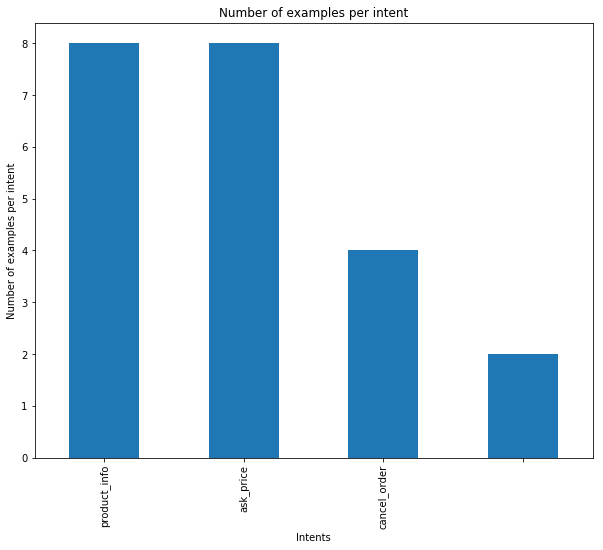

In [14]:
# Read the training data from a JSON file located at "data/training_data.json"
training_data = pd.read_json("data/training_data.json")

# Generate a distribution plot of examples within the training data
examplesDist_plot(training_data)


In [15]:
def trainModel(pipeline, model_dir):
    """
    Train a model using the provided pipeline configuration and save it to the specified directory.

    :param pipeline: Path to the pipeline configuration to be loaded as the config in the Trainer.
    :param model_dir: Directory where the trained model will be stored after training.
    :return: The model directory where the trained model has been saved.
    """
    # Load the training data from a JSON file
    path_to_data = "./data/training_data.json"
    training_data = load_data(path_to_data)

    # Create a Trainer using the specified pipeline configuration
    trainer = Trainer(config.load(pipeline))

    # Train the model using the training data
    interpreter = trainer.train(training_data)

    # Define the path to save the trained model
    path_to_model = "./models/current/" + model_dir

    # Persist and save the trained model to the specified model directory
    model_directory = trainer.persist(path_to_model)

    # Return the directory where the trained model has been saved
    return model_directory


In [16]:
def evaluateModel(pathToData, model_dir):
    """
    Evaluate a model using the provided test data and save evaluation results to the model directory.

    :param pathToData: Path to the test data in JSON format.
    :param model_dir: Directory where the evaluation results will be saved.
    """
    # Set the path to the test data (this line seems redundant as the pathToData parameter is not used)
    path_to_data = "./data/test_data.json"

    # Check if the "evaluation" directory exists within the model directory, create it if not
    if not os.path.exists(model_dir + "/evaluation"):
        os.mkdir(model_dir + "/evaluation")
        print("Directory 'evaluation' Created")

    # Define paths for saving evaluation results
    errors_path = model_dir + "/evaluation/errors.json"
    confmat_path = model_dir + "/evaluation/confmat"
    intent_hist_path = model_dir + "/evaluation/hist"

    # Run the evaluation with the provided test data and save results to the specified paths
    run_evaluation(
        path_to_data,  # Path to the test data (seems to be hard-coded and not based on the 'pathToData' parameter)
        model_dir,
        errors_filename=errors_path,
        confmat_filename=confmat_path,
        intent_hist_filename=intent_hist_path
    )


Epochs: 100%|██████████| 300/300 [00:01<00:00, 236.92it/s, loss=0.082, acc=1.000]


The training took  0.03191545009613037  mins for execution
d:\PROJECTS\rasa-nlu-chatbot\modular_code\modular_code\./models/current/./Tensorflow_embedings_model\default\model_20230210-093402
Directory  evaluation  Created 
INFO:tensorflow:Restoring parameters from d:\PROJECTS\rasa-nlu-chatbot\modular_code\modular_code\./models/current/./Tensorflow_embedings_model\default\model_20230210-093402\component_4_EmbeddingIntentClassifier.ckpt


100%|██████████| 8/8 [00:00<00:00, 196.55it/s]


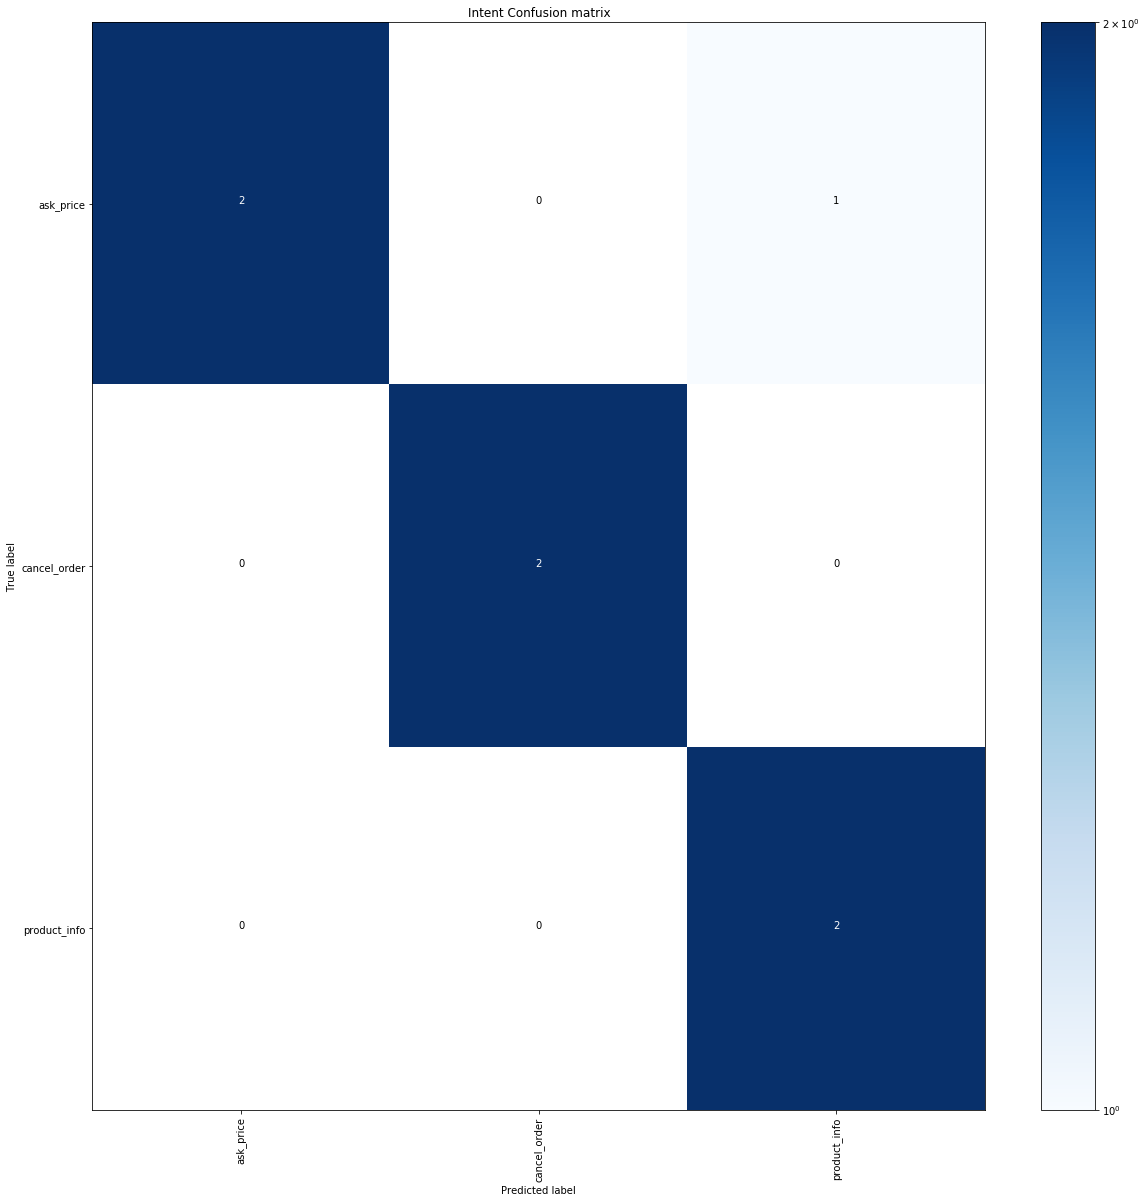

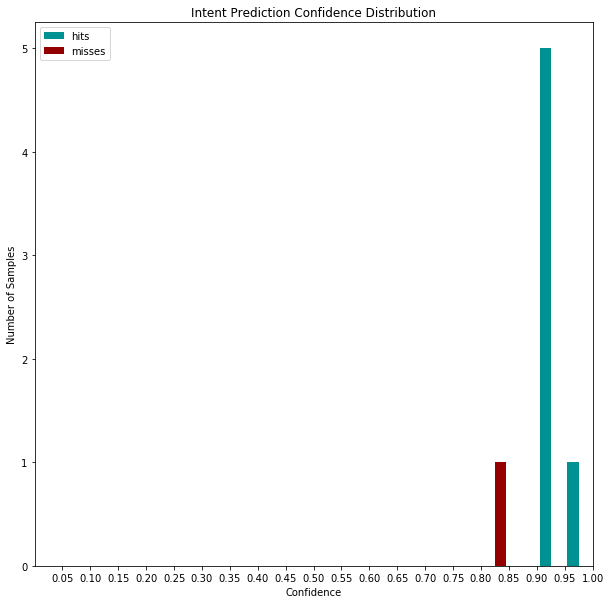

In [28]:
# Record the start time before training the model
start = time.time()

# Train the model using the specified pipeline configuration and save it to the specified model directory
model_dir = trainModel("./data/Tensorflow.config.yml", "./Tensorflow_embedings_model")

# Record the end time after training the model
end = time.time()

# Calculate and print the time taken for training in minutes
print("The training took ", (end - start) / 60, " mins for execution")

# Print the path to the trained model directory
print(model_dir)

# Evaluate the trained model using test data
evaluateModel("548_training_examples", model_dir)


Fitting 2 folds for each of 6 candidates, totalling 12 fits
The training took  0.009190050760904948  mins for execution
d:\PROJECTS\rasa-nlu-chatbot\modular_code\modular_code\./models/current/Spacy_model\default\model_20230210-093412
Directory  evaluation  Created 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
100%|██████████| 8/8 [00:00<00:00, 90.39it/s]


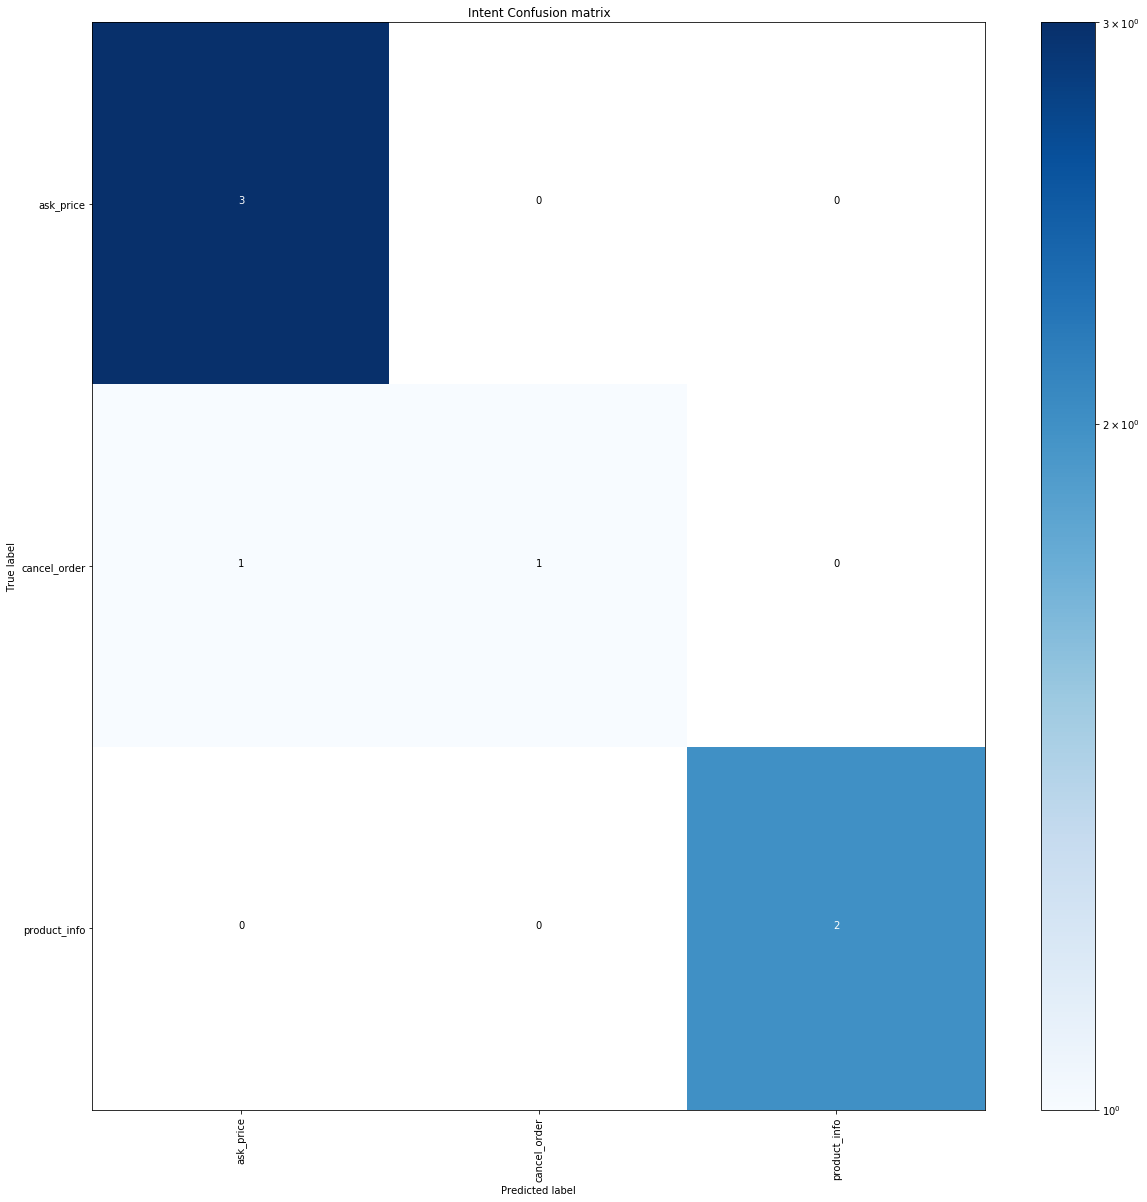

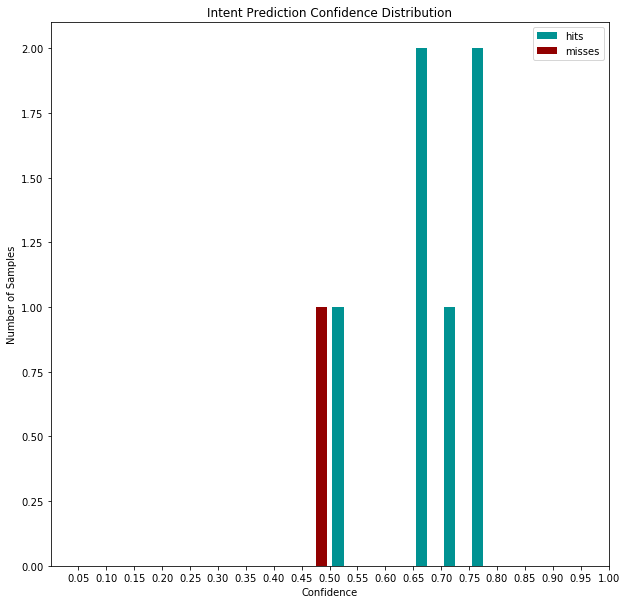

In [29]:
# Record the start time before training the model
start = time.time()

# Train the model using the specified Spacy pipeline configuration and save it to the "Spacy_model" directory
model_dir = trainModel("./data/spacy_config.yml", "Spacy_model")

# Record the end time after training the model
end = time.time()

# Calculate and print the time taken for training in minutes
print("The training took ", (end - start) / 60, " mins for execution")

# Print the path to the trained model directory
print(model_dir)

# Evaluate the trained Spacy model using test data in the "548_training_examples" dataset
evaluateModel("548_training_examples", model_dir)


In [21]:
from rasa_nlu.model import Metadata, Interpreter

In [30]:
# Load the trained model from the specified model directory
model_directory = "./models/current/Spacy_model/default/model_20230210-091453"
interpreter = Interpreter.load(model_directory)


In [31]:
print(interpreter.parse('Can you tell me about television'))

{'intent': {'name': 'product_info', 'confidence': 0.9102788810425014}, 'entities': [{'start': 22, 'end': 32, 'value': 'television', 'entity': 'product', 'confidence': 0.9748137087549501, 'extractor': 'CRFEntityExtractor'}], 'intent_ranking': [{'name': 'product_info', 'confidence': 0.9102788810425014}, {'name': 'ask_price', 'confidence': 0.04567811423351092}, {'name': 'cancel_order', 'confidence': 0.0440430047239876}], 'text': 'Can you tell me about television'}


In [32]:
print(interpreter.parse('i live in Canada'))

{'intent': {'name': 'product_info', 'confidence': 0.8206934308624474}, 'entities': [{'start': 10, 'end': 16, 'value': 'canada', 'entity': 'location', 'confidence': 0.9052570743457238, 'extractor': 'CRFEntityExtractor'}], 'intent_ranking': [{'name': 'product_info', 'confidence': 0.8206934308624474}, {'name': 'ask_price', 'confidence': 0.10192392216643048}, {'name': 'cancel_order', 'confidence': 0.07738264697112239}], 'text': 'i live in Canada'}


In [33]:
# connecting with MongoDB
from pymongo import MongoClient

In [34]:
from pymongo import MongoClient
import requests

class IntentFlow:
    def __init__(self, client_id):
        """
        Initialize the IntentFlow class.

        :param client_id: Client ID used to store intent flow per client.
        """
        # Connect to the MongoDB client on 'localhost' and port '27017'.
        self.mongo_client = MongoClient('localhost:27017')
        
        # Select the 'chatflowdb' database.
        self.db = self.mongo_client.chatflowdb
        
        # Access the 'chatflow' collection within the database.
        self.intent_table = self.db['chatflow']
        
        # Store the client ID for future use.
        self.client_id = client_id

    def add_flows(self, flow):
        """
        Insert a specified flow per client.

        :param flow: Flow to be inserted.
        :return: None
        """
        self.intent_table.insert_one({
            "client_id": self.client_id,
            "flow": flow,
        })

    def resolve_api(self, url):
        """
        Resolve an API by making a GET request to the provided URL and return the response.

        :param url: URL to resolve as an API.
        :return: Response from the requested API.
        """
        response = requests.request("GET", url)
        return response.text

    def extract_api(self, intent_name):
        """
        Extract API details for a given intent name.

        :param intent_name: Name of the intent for which API details are needed.
        :return: Response from the resolved API.
        """
        response = self.intent_table.find_one({"client_id": self.client_id, "flow.intent": intent_name})
        api_url = response['flow']['api_data']['url']
        print(api_url, "api_url")
        response = self.resolve_api(api_url)
        return response

    def get_flows(self):
        """
        Return all flows associated with the given client ID.
        """
        response = self.intent_table.find({"client_id": self.client_id})
        return list(response)

    def get_slots_by_intent(self, intent_name):
        """
        Return slots that need to be filled before triggering an API for a given intent.

        :param intent_name: Name of the intent for which slots are needed.
        :return: Slots that need to be filled.
        """
        response = self.intent_table.find_one({
            "client_id": self.client_id,
            "flow.intent": intent_name
        })
        slots = None
        if response:
            slots = response['flow']['entities']
        return slots

class ContextManager:
    def __init__(self, client_id, chat_id):
        """
        Initialize the ContextManager class.

        :param client_id: Client ID of the context.
        :param chat_id: Chat ID to be stored, so the context is managed per chat window for each client.
        """
        # Connect to the MongoDB client on 'localhost' and port '27017'.
        self.mongo_client = MongoClient('localhost:27017')
        
        # Select the 'chatflowdb' database.
        self.db = self.mongo_client.chatflowdb
        
        # Access the 'chatsession' collection within the database.
        self.chat_session = self.db['chatsession']
        
        # Store the client ID and chat ID for future use.
        self.client_id = client_id
        self.chat_id = chat_id

    def get_context(self):
        """
        Return the context stored for a given chat ID.
        """
        response = self.chat_session.find_one({"chat_id": self.chat_id})
        return response

    def update_slots(self, intent=None, entity=None):
        """
        Update intent or entity for a given chat ID.

        :param intent: Intent to be updated.
        :param entity: Entity to be updated.
        :return: None
        """
        if intent:
            self.chat_session.find_one_and_update(
                {"chat_id": self.chat_id},
                {"$set": {"intent": intent}},
                upsert=True
            )
        if entity:
            self.chat_session.find_one_and_update(
                {"chat_id": self.chat_id},
                {"$push": {"entity": entity}},
                upsert=True
            )

    def get_filled_slots(self):
        """
        Return all the filled slots in the given context for a given chat ID.
        """
        response = self.chat_session.find_one({"chat_id": self.chat_id})
        filled_slots = None
        if response and "entity" in response:
            filled_slots = response['entity']
        return filled_slots

    def get_slots(self, intent_name):
        """
        Return slots that are not filled for a given intent.

        :param intent_name: Intent name to check for not-filled slots.
        :return: Slots that are not filled.
        """
        intent_flow_obj = IntentFlow(self.client_id)
        slots = intent_flow_obj.get_slots_by_intent(intent_name)

        if slots:
            filled_slots = self.get_filled_slots()
            not_filled_slots = [ent for ent in slots if ent['entity'] not in filled_slots]
            return not_filled_slots
        else:
            print("No flow found for this intent")


In [35]:
import requests

def resolve_api(url):
    """
    Resolve an API by making a GET request to the specified URL and return the response in JSON format.

    :param url: URL to resolve as an API.
    :return: Response from the API in JSON format.
    """
    url = "https://dezyre.free.beeceptor.com/my/api/path"
    response = requests.request("GET", url)
    return response.json()

def process_message(message, client_id, chat_id):
    """
    Process a chat message from the user using a ML model.

    :param message: Chat message to be processed by the ML models.
    :param client_id: Client ID.
    :param chat_id: Chat ID for storing context.
    :return: Response or prompt for the unfulfilled slots defined for the given intent.
    """
    # Take the chat message and predict it using Rasa NLU pipeline
    response = interpreter.parse(message)
    print(response, "response from Rasa")
    intent_pred = response['intent']['name']
    intent_conf = response['intent']['confidence']

    intent = None
    if intent_conf > 0.90:
        intent = intent_pred

    entities_pred = response['entities']

    context_manager = ContextManager(client_id, chat_id)

    # Check if there is an existing intent
    try:
        context = context_manager.get_context()
        print(context, "got context as this")
        if "intent" in context.keys():
            intent_context = context['intent']
            print(intent_context, "intent_context")
            print(intent, "intent predicted")
            if intent_context == intent:
                intent = intent_context
            else:
                if intent:
                    return "Do you want to change the intent?"
                else:
                    # It means there is no intent now, so we will continue with the intent in context
                    intent = intent_context
    except:
        # No context has been saved yet for this chat yet
        print("updating context as intent", intent)
        if intent:
            context_manager.update_slots(intent=intent)

    if entities_pred:
        for each_ent in entities_pred:
            entity = each_ent['entity']
            value = each_ent['value']
            conf = each_ent['confidence']
            if conf > 0.60:
                context_manager.update_slots(entity=entity)

    response = context_manager.get_slots(intent)
    if response:
        prompt_question = response[0]['prompt']
        return prompt_question
    else:
        intent_obj = IntentFlow(client_id)
        response = intent_obj.extract_api(intent)
        return response


In [36]:
chat_id="0036"
client_id=4

In [37]:
message = "Can you tell me about television ?"

In [ ]:
process_message(message,client_id,chat_id)

In [ ]:
message = "i live in Canada "

In [ ]:
process_message(message,client_id,chat_id)

 we basically have 3 types of intent

1) product_info :Depends on these entities : [product,location]

2) ask_price :Depends on these entities : [product,location]

3) cancel_order :Depends on these entities : [order_id]


In [ ]:
flow_1={
    "intent":"product_info",
    "entities":[
        {"entity":"product","prompt":"can you please enter what are you searching ?"},
        {"entity":"location","prompt":"Please enter your location ?"}
    ],
    "api_data":{
        "url":"https://dezyre.free.beeceptor.com/my/api/path",
            }
    }

flow_2 = {
    "intent":"ask_price",
     "entities":[
        {"entity":"product","prompt":"can you please enter what are you searching ?"},
        {"entity":"location","prompt":"Please enter your location ?"}
    ],
       "api_data":{
        "url":"https://dezyre.free.beeceptor.com/my/api/path",
            }
    }

flow_3 = {
    "intent":"ask_price",
     "entities":[
        {"entity":"order_id","prompt":"Please enter your order id ?"},
    ],
       "api_data":{
        "url":"https://dezyre.free.beeceptor.com/my/api/path",
            }
    }

In [ ]:
intent_flow_obj=IntentFlow(client_id)
intent_flow_obj.add_flows(flow_1)
intent_flow_obj.add_flows(flow_2)
intent_flow_obj.add_flows(flow_3)

In [ ]:
intent_flow_obj.get_slots_by_intent("product_info")

[{'entity': 'product',
  'prompt': 'can you please enter what are you searching ?'},
 {'entity': 'location', 'prompt': 'Please enter your location ?'}]

---